In [1]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = False
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

/Users/ashwiniyengar/Documents/Sem 1/Deep Learning/Final Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/p3/znd79qns6pg91z5pd1gmthf00000gp/T/ipykernel_39027/65167321.py:15: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:


Using device: cpu


100%|██████████| 30/30 [05:53<00:00, 11.78s/it]


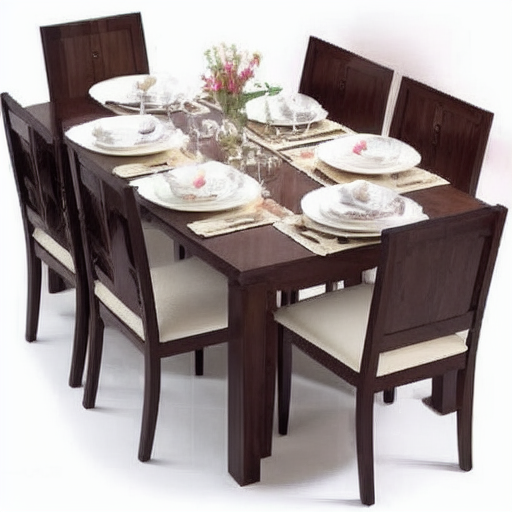

In [48]:
## TEXT TO IMAGE
prompt = "A dining table set in a kitchen"
#prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
#prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/001.jpg"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.6

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [46]:
def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

In [47]:
import numpy as np
WIDTH = 512
HEIGHT = 512
device = "cpu"
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8
image_path = "../images/001.jpg"
input_image = Image.open(image_path)
print(input_image)
input_image_tensor = input_image.resize((WIDTH, HEIGHT))
input_image_tensor = np.array(input_image_tensor)
# (Height, Width, Channel) -> (Height, Width, Channel)
input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)
# (Height, Width, Channel) -> (Height, Width, Channel)
input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
            # (Height, Width, Channel) -> (Batch_Size, Height, Width, Channel)
input_image_tensor = input_image_tensor.unsqueeze(0)
            # (Batch_Size, Height, Width, Channel) -> (Batch_Size, Channel, Height, Width)
input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)

            

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=425x430 at 0x1752C9150>


In [13]:
models

{'clip': CLIP(
   (embedding): CLIPEmbedding(
     (token_embedding): Embedding(49408, 768)
   )
   (layers): ModuleList(
     (0-11): 12 x CLIPLayer(
       (layernorm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (attention): SelfAttention(
         (in_proj): Linear(in_features=768, out_features=2304, bias=True)
         (out_proj): Linear(in_features=768, out_features=768, bias=True)
       )
       (layernorm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
       (linear_1): Linear(in_features=768, out_features=3072, bias=True)
       (linear_2): Linear(in_features=3072, out_features=768, bias=True)
     )
   )
   (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
 ),
 'encoder': VAE_Encoder(
   (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): VAE_ResidualBlock(
     (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
     (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [31]:
clip_model = models['diffusion']
count = 0
for param in clip_model.parameters():
    count += 1

print(count)

654


In [24]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Example dataset class for loading images
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = os.listdir(image_dir)  # List all files in the directory
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get the image file path
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name)

        # Apply transformations (e.g., normalization, resizing)
        if self.transform:
            image = self.transform(image)

        # Assuming the target is the same as the input (for simplicity)
        target = image  # Replace this with real target data if necessary

        return image, target

# Define transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Initialize dataset and dataloader
image_dir = "../images"  # Path to your image directory
dataset = CustomImageDataset(image_dir=image_dir, transform=transform)

# Define DataLoader to handle batching
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [26]:
import torch

# Freeze the CLIP model (set requires_grad = False for its parameters)
clip_model = models['clip']
for param in clip_model.parameters():
    param.requires_grad = False  # Freeze the CLIP model parameters

# Define the optimizer (only for encoder and decoder)
optimizer = torch.optim.Adam(
    list(models['encoder'].parameters()) + list(models['decoder'].parameters()), 
    lr=1e-4
)

# Define loss function (you can replace this with your actual loss function)
loss_fn = torch.nn.MSELoss()  # Example: Mean Squared Error loss


In [33]:
# Training loop
num_epochs = 1  # Example number of epochs
for epoch in range(num_epochs):
    models['encoder'].train()
    models['decoder'].train()

    for batch in data_loader:  # This is where data is provided by DataLoader
        inputs, targets = batch  # inputs and targets from the data_loader

        # Zero the gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass through the encoder and decoder (clip is frozen)
        #outputs = models['decoder'](models['encoder'](inputs))
    """
        # Compute loss (use your own loss function)
        loss = loss_fn(outputs, targets)  # loss_fn should be defined

        # Backward pass (only encoder/decoder parameters will be updated)
        loss.backward()

        # Step the optimizer
        optimizer.step()
    """
    # Print the loss for this epoch
    #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
